# Graph financial fraud classification using Graph Isomorphism Network (GIN)

**Authors:** 
- Elise Sainderichin: <elise.sainderichin@datarobot.com>
- Ouadie Gharroudi: <ouadie.gharroudi@datarobot.com>  

**Date created:** January 31, 2025

This accelerator demonstrates the end-to-end implementation and integration of a Graph Isomorphism Network (GIN) as a custom model task in DataRobot. It serves multiple purposes, including model development, local testing, and integration with DataRobot’s custom modeling framework.  

## Primary objectives  

1. Demonstrate the complete pipeline for adding a custom graph-based task to DataRobot.  
2. Illustrate DataRobot's custom model hooks implementation:  
   - **`transform`**: Preprocess JSON graph data into DGL format.  
   - **`fit`**: Train the GIN model and implicitly save it.  
   - **`score`**: Score the data in prediction mode.  
   - **`load_model`**: Load pre-trained models.  
   - **Note:** DRUM hooks automatically call `transform` before executing the `fit` and `score` hooks.  

## Implementation process  

1. **Manual implementation of the DRUM process**  
   - Demonstrates the DataRobot process through DRUM and replicates the workflow of how hooks are executed.  
   - Provides a step-by-step breakdown of data transformation, model training, and prediction.  
   - **Notes:**  
     - The full implementation of the hooks is available in `custom.py`.  
     - The GIN model is defined in `GIN_model.py`.  

2. **Model testing using DRUM in a local environment**  
   - This stage is important as it allows for faster iteration.  
   - Enables local testing within a development environment.  
   - Speeds up the development cycle.  
   - Validates hooks before DataRobot integration.  

3. **DataRobot integration**  
   - A process for deploying a custom task to DataRobot.  
   - Integrates with DataRobot's Leaderboard.  
   - Automated validation and threshold optimization.  

### Notes  
- **Demo configuration**: For demonstration purposes, this notebook utilizes:  
  - Shortened training time.  
  - Simplified hyperparameters.  
  - Reduced neural network complexity.  

## Use case

### Detecting fraudulent transactions using network graphs

Financial fraud is a growing concern, with fraudulent transactions causing billions in losses annually. Fraudulent activities often involve intricate money transfers across multiple accounts, making them difficult to detect using traditional rule-based methods.

To address this, you can analyze transaction networks as **graphs**, where:
- **Bank accounts** are represented as **nodes (vertices)**.
- **Transactions between accounts** are represented as **edges (connections)**.
- The objective is to classify each transaction network as either **fraudulent** (`label = 1`) or **legitimate** (`label = 0`).

### Business impact

- **Prevent financial losses** by identifying fraudulent transactions early.
- **Enhance fraud detection systems** using network-based analysis.
- **Improve compliance** with anti-money laundering (AML) regulations.
 
While this accelerator focuses on financial fraud detection, the GIN model is applicable to various tasks, including: 

- **Molecular property prediction**  
- **Social network analysis**  
- **Recommendation systems**  

## Dataset overview

### Dataset structure

Each row in the dataset represents a **graph-based transaction network** with three key columns:

| **Column** | **Description** |
|------------|---------------|
| **ID** | Unique identifier for each transaction network. |
| **graph** | A JSON-like representation of the financial network, containing: <br> - **`"vertices"`** → A list of unique bank account IDs in the transaction network. <br> - **`"edges"`** → List of transactions between accounts (pairs of connected nodes). |
| **label** | `0` → Legitimate transactions, `1` → Fraudulent transactions. |

### Example record (graph-based network)
```json
{
    "vertices": [0, 1, 2, 3, 4, 5],
    "edges": [(0, 1), (1, 2), (2, 3), (4, 5)]
}
```

### Nodes and edges in the graph
- **Nodes (vertices):** Represent **bank accounts** (e.g., `0, 1, 2, 3, 4, 5`).
- **Edges (transactions):** Represent **money transfer pairs** (e.g., `(0,1)`, `(1,2)`, etc.).
- **Label (`0` or `1`):** Indicates whether the transactions in the network contain fraud.

---

### Fraud patterns in the dataset

#### Legitimate transactions (`label = 0`)
- Regular transactions between accounts.
- No unusual or excessive connections.

#### Fraudulent transactions (`label = 1`)
- Suspicious transaction loops or sudden, high-volume transfers.
- Interconnected accounts forming a **"fraud ring"**.
- High number of transactions between certain accounts.

## Setup

### Prerequisites

Before running the accelerator, ensure that all required dependencies are installed. Run the following command to install the necessary packages:  

```bash
pip install --force-reinstall -r requirements.txt
```

This will **force reinstall** all dependencies listed in `requirements.txt`, ensuring compatibility with DRUM.

In [1]:
import json
from pathlib import Path
import pickle
import random
import urllib.parse

import datarobot as dr
from datarobot.enums import CUSTOM_TASK_TARGET_TYPE
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from torch.utils.data import DataLoader

In [2]:
import sys

sys.path.append(str(Path.cwd() / "custom_task"))

from custom import fit, graph_2_dgl, load_model, score, transform

In [3]:
import warnings

warnings.filterwarnings("ignore")

## Data loading and exploration

In this section, load and explore the graph dataset. The data is stored in CSV format with a special 'graph' column containing JSON-encoded graph structures.

In [4]:
csv_url = "https://s3.us-east-1.amazonaws.com/datarobot_public_datasets/ai_accelerators/financial_network_graph.csv"
df = pd.read_csv(csv_url)

### Graph Visualization

Implement a custom visualization function using Plotly to render graph structures. This helps you understand the topology and characteristics of the graph data.

#### `visualize_json_graph` function

In [5]:
def visualize_json_graph(data):
    """
    Convert a JSON-formatted graph to a Plotly figure.

    Parameters
    ----------
    data : str or dict
        A JSON string containing "vertices", "edges", "label", and optionally "idx".

    Returns
    -------
    plotly.graph_objects.Figure
        A Plotly figure visualizing the graph.
    """
    # Parse JSON string

    if isinstance(data, str):
        graph_dict = json.loads(data)
    elif isinstance(data, dict):
        graph_dict = data
    else:
        raise TypeError("Input data must be a JSON string or a dictionary.")

    vertices = graph_dict.get("vertices", [])
    edges = graph_dict.get("edges", [])

    # Create NetworkX graph
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(vertices)
    nx_graph.add_edges_from(edges)

    # Generate layout positions
    pos = nx.spring_layout(nx_graph)

    # Edge trace
    edge_trace = go.Scatter(
        x=[pos[src][0] for src, dst in edges] + [None for _ in edges],
        y=[pos[src][1] for src, dst in edges] + [None for _ in edges],
        mode="lines",
        line=dict(width=1, color="#888"),
        hoverinfo="none",
    )

    # Node trace (with labels as node IDs)
    node_trace = go.Scatter(
        x=[pos[node][0] for node in vertices],
        y=[pos[node][1] for node in vertices],
        mode="markers+text",
        text=[str(node) for node in vertices],
        textposition="middle center",
        hoverinfo="text",
        marker=dict(color="blue", size=10, line_width=1, line_color="black"),
    )

    # Create and return figure
    return go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=f"Graph Visualization",
            title_x=0.5,
            showlegend=False,
            hovermode="closest",
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        ),
    )

#### Graph exploration

Number of nodes in the Network:  12


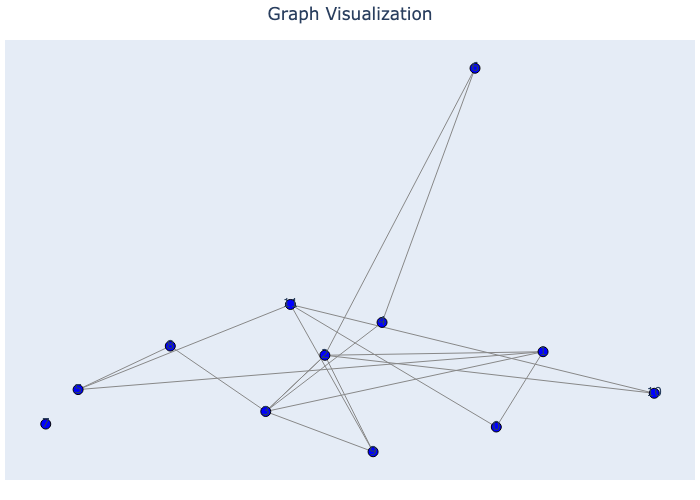

In [6]:
index = 400
json_graph = json.loads(df["graph"].iloc[index])
# graph_dict = json.loads(df["graph"].iloc[0])
print("Number of nodes in the Network: ", len(json_graph.get("vertices")))
fig = visualize_json_graph(json_graph)

# Forces static PNG rendering inside the notebook use fig.show() for interactive plot.
pio.show(fig, renderer="png")

## Modeling pipeline  

### Custom task structure

The implementation follows DataRobot's custom model requirements and consists of the following components:  

- **Model class (`GIN_model.py`)**:  
   - Implements the core GIN architecture.  
   - Provides standard methods: `fit()`, `predict()`, `save_model()`, and `load_model()`.  
   - Manages model persistence and state handling.  

- **Custom hooks (`custom.py`)**:  
   - `load_model()`: Loads trained model artifacts.  
   - `transform()`: Preprocesses input data.  
   - `fit()`: Handles model training.  
   - `score()`: Generates predictions.  
   - Implements DataRobot's standard interface for custom models.  

- **Requirements (`requirements.txt`)**:  

   ```plaintext
   numpy<2.0  
   pandas==2.2.3  
   networkx==3.4.2  
   plotly==6.0.0  
   torch==2.6.0  
   dgl==1.1.0  
   scikit-learn==1.6.1  
   datarobot-drum==1.16.2  
   ```

In this section, follow the same process that DRUM executes for `fit` and `score`.

## Data preprocessing  

Split the data into training and testing datasets using an 80-20 split ratio. The data is shuffled to ensure a random distribution of samples.  

Since this is a demonstration, this accelerator does not perform cross-validation, hyperparameter exploration, or a thorough investigation of the network architecture. DataRobot recommends conducting these steps in further development.  

For customization, the model’s hyperparameters can be adjusted in the `fit` method within `custom.py`, where they are defined as follows:  

```python
model_params = {
    "num_layers": 2,
    "num_mlp_layers": 2,
    "input_dim": 1,
    "hidden_dim": 20,
    "output_dim": 2,
    "final_dropout": 0.0,
    "learn_eps": 0.01,
    "graph_pooling_type": "sum",
    "neighbor_pooling_type": "sum"
}
```

**References:** ["How Powerful are Graph Neural Networks"](https://arxiv.org/abs/1810.00826)



In [7]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
full_data = df.sample(frac=1).reset_index(drop=True)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

## `transform` hook: graph transformation

The JSON graph data is transformed into DGL (Deep Graph Library) format for compatibility with our PyTorch-based GIN model.

In [8]:
transformed_train_data = transform(train_df, None)

##  `fit` hook: training the GIN model

For the GIN class definition, please refer to `GIN_model.py`, where you implement the `GIN` class.

In [9]:
current_directory = Path.cwd()
print(current_directory)

/Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification


In [10]:
output_dir = Path.cwd()  # current location
fit(transformed_train_data, train_df["label"], output_dir)

=== Training the GIN model ===
Epoch [1/5], Loss: 1.6167
Epoch [2/5], Loss: 0.7449
Epoch [3/5], Loss: 0.7037
Epoch [4/5], Loss: 0.7095
Epoch [5/5], Loss: 0.6647
Model saved as /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/gin_model.params and /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/gin_model.weights


## `score` hook: predicting data with the GIN Model  

Note that in DRUM, the model is saved to disk during the `fit` hook and is expected to be loaded using the `load_model` hook.  

Additionally, before passing data to the `score` function, it must first go through the `transform` hook to ensure proper preprocessing.

In [11]:
model = load_model(output_dir)
transformed_test_data = transform(test_df, None)
df_prediction = score(transformed_test_data, model)

Model loaded from /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/gin_model.params and /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/gin_model.weights


## Quick evaluation check  

This section implements a quick evaluation check to assess the model's output.  

It includes:  
- A function to heuristically select the best threshold.  
- An example of prediction quality investigation.  


In [12]:
# Finds the best threshold for binary classification based on the F1 score


def find_best_threshold(true_labels, probabilities_1):
    thresholds = [i / 100 for i in range(1, 100)]
    return max(
        (
            (
                threshold,
                f1_score(true_labels, (probabilities_1 >= threshold).astype(int)),
            )
            for threshold in thresholds
        ),
        key=lambda x: x[1],
    )


true_labels = test_df["label"]  # Should be done on training data or calibration data
probabilities_1 = df_prediction["1"]

best_threshold, best_f1 = find_best_threshold(true_labels, probabilities_1)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.2f}")

Best Threshold: 0.28, Best F1 Score: 0.49


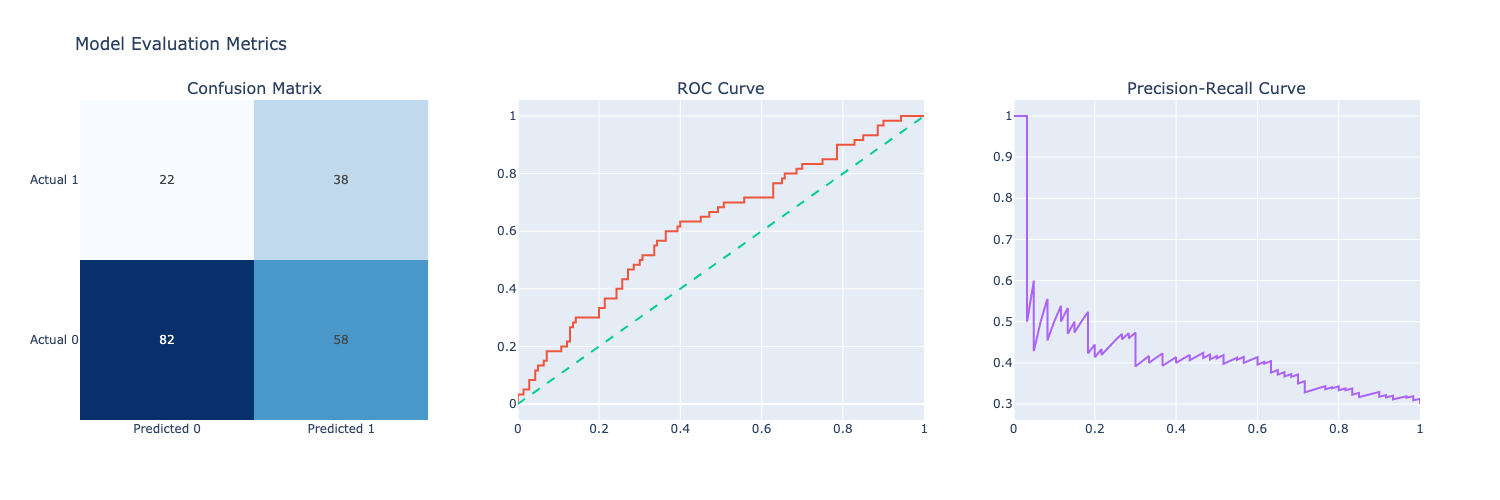

In [13]:
true_labels = test_df["label"]
probabilities = df_prediction["1"]  # Probability of class 1

threshold = best_threshold
predicted_labels = (probabilities >= threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute evaluation metrics
roc_auc = roc_auc_score(true_labels, probabilities)
average_precision = average_precision_score(true_labels, probabilities)

# Generate ROC Curve
fpr, tpr, _ = roc_curve(true_labels, probabilities)

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, probabilities)

# Create subplots
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=("Confusion Matrix", "ROC Curve", "Precision-Recall Curve"),
    column_widths=[0.3, 0.35, 0.35],
)

# Add Confusion Matrix
fig.add_trace(
    go.Heatmap(
        z=cm,
        x=["Predicted 0", "Predicted 1"],
        y=["Actual 0", "Actual 1"],
        colorscale="Blues",
        showscale=False,
        text=cm,
        texttemplate="%{text}",
    ),
    row=1,
    col=1,
)

# Add ROC Curve
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode="lines", name=f"ROC Curve (AUC = {roc_auc:.2f})"),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Random", line=dict(dash="dash")),
    row=1,
    col=2,
)

# Add Precision-Recall Curve
fig.add_trace(
    go.Scatter(
        x=recall,
        y=precision,
        mode="lines",
        name=f"PR Curve (AP = {average_precision:.2f})",
    ),
    row=1,
    col=3,
)

# Update layout
fig.update_layout(
    title_text="Model Evaluation Metrics", height=500, width=1500, showlegend=False
)

# Show the plots
# Forces static PNG rendering inside the notebook use fig.show() for interactive plot.
pio.show(fig, renderer="png")
# fig.show()

## Test the custom model locally using DRUM

Before deploying to **DataRobot**, validate your model locally using [**DRUM**](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-drum.html) to ensure correct training and inference. This accelerates debugging and iteration.  

DataRobot User Model ([**DRUM**](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-drum.html)) is a CLI tool that enables you to work with Python, R, and Java custom models. It allows you to quickly test custom tasks, models, and environments locally before uploading them to DataRobot. You can download DRUM from [PyPI](https://pypi.org/project/datarobot-drum/). 

By testing our custom task using **DRUM**, we ensure that the task integrates seamlessly with DataRobot and is ready for training and deployment.  

## Custom model directory structure  

DRUM requires a `custom.py` file for model logic and a `requirements.txt` file for dependencies. Your directory structure should look like this:  

```bash
custom_task/
├── custom.py            # Model logic & DRUM hooks
├── GIN_model.py         # Custom model architecture
├── requirements.txt     # Dependencies
```

All files in `custom_task/` will be copied to the **output directory** during training.  


## Running DRUM fit  

Train and validate your model using the following command:  

```bash
drum fit \
    --code-dir ./custom_task \  
    --target-type <binary|regression|multiclass> \
    --target <target_column> \
    --input <data.csv> \
    --output <output_dir>
```

## Understanding the `--output` directory  

The `--output` directory stores:  

- **Trained model** – Used for scoring and deployment.
- **Logs & metadata** – Useful for debugging.
- **Custom task files** – Required for execution.


In [14]:
# Find the current directory
print(current_directory)

/Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification


In [15]:
%%sh
mkdir -p drum_output_dir

In [16]:
%%sh
drum fit \
    --code-dir ./custom_task \
    --target-type binary \
    --target label \
    --positive-class-label 1 \
    --negative-class-label 0 \
    --input ./financial_network_graph.csv \
    --output ./drum_output_dir

Starting Fit


=== Training the GIN model ===
/Users/ouadie.gharroudi/Documents/working/07-Graph-AI/00-GraphML/custom-training/custom-task-gin/prod-venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
Epoch [1/5], Loss: 1.1104
Epoch [2/5], Loss: 0.7184
Epoch [3/5], Loss: 0.6917
Epoch [4/5], Loss: 0.6635
Epoch [5/5], Loss: 0.6859
Model saved as /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/gin_model.params and /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/gin_model.weights


Fit successful
Files were overwritten: {'/Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/GIN_model.py', '/Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/custom.py', '/Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/requirements.txt'}
Starting Prediction


2025-01-31 16:10:31,848 WARNING drum:  
                        The last 10 predictions from the main predict run were:        0        1
0.664823 0.335177
0.664823 0.335177
0.846903 0.153097
0.846903 0.153097
0.641277 0.358723
0.640785 0.359215
0.640785 0.359215
0.784615 0.215385
0.784615 0.215385
0.415772 0.584228
                        However when we reran predictions on the same data, we got:        0        1
0.682166 0.317834
0.682166 0.317834
0.659856 0.340144
0.659856 0.340144
0.650198 0.349802
0.709405 0.290595
0.709405 0.290595
0.663665 0.336335
0.663665 0.336335
0.523854 0.476146.
                        The sample used to calculate prediction reruns can be found in this file: /var/folders/_y/6jvbd7ws2579dmy8cbm2k9h80000gq/T/tmpzsq6zc8s.csv


Prediction successful for fit validation
Success 🎉


## Run DRUM score (Inference)

### Score command  
Use the following commands to run inference and validate the model inference.
```bash
drum score \
    --code-dir <trained_model_dir> \
    --target-type <binary|regression|multiclass> \
    [--positive-class-label <positive_label>] \
    [--negative-class-label <negative_label>] \
    --input <data.csv> \
    --output <predictions.csv>
```


In [17]:
%%sh
drum score \
    --code-dir ./drum_output_dir \
    --positive-class-label 1 \
    --negative-class-label 0 \
    --target-type binary  \
    --input ./financial_network_graph.csv \
    --output predictions.csv 

/Users/ouadie.gharroudi/Documents/working/07-Graph-AI/00-GraphML/custom-training/custom-task-gin/prod-venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Model loaded from /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/gin_model.params and /Users/ouadie.gharroudi/Documents/GitHub/data-science-scripts/graph_financial_fraud_classification/drum_output_dir/gin_model.weights


## DataRobot integration

This section outlines how to integrate a custom task into DataRobot using the API. This process allows you to push, configure, and train your model on DataRobot’s platform, ensuring it is ready for deployment and inference.

## Connect to DataRobot
Before starting, you need to connect to DataRobot via the client. The DataRobot API offers different options for connecting to the platform. You can find more details in the [API Quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html).

In [18]:
# The URL may vary depending on your hosting preference, this example is for DataRobot Managed AI Cloud
DATAROBOT_ENDPOINT = (
    "https://app.datarobot.com/api/v2"  # Replace with your actual endpoint
)

# The API Token can be found by clicking the avatar icon and then </> Developer Tools
DATAROBOT_API_TOKEN = "DataRobot-API-Key"  # Replace with your actual API key

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
)

dr.client._global_client = client

## Select the execution environment

Before uploading the model, you need to **define the execution environment** where it will run. This environment must include all necessary dependencies for the model to function properly.  

DataRobot offers two options for execution environments:  

- **Pre-built environments** – DataRobot provides several **ready-to-use** environments for training and deployment. These environments come with common dependencies and can be used as a **base environment** to ensure compatibility.  

- **Custom environments** – You can create a **custom environment** tailored to your model’s needs. The best practice is to **start with a pre-built environment** and add only the required dependencies.  

You can find **example environments on GitHub**:  
- **[DataRobot public drop-in environments](https://github.com/datarobot/datarobot-user-models/tree/master/public_dropin_environments)**  

For more details, refer to the **[DataRobot documentation](https://docs.datarobot.com/en/docs/mlops/deployment/custom-models/custom-model-environments/index.html)**.  



### Set up the custom environment  

For this use case, DataRobot provides a **custom environment (`python311_gin`)**, which includes all necessary libraries for the Gin classifier. You can find the **Docker context** for this environment and recreate it locally using the **`python311_gin`** folder.  

To **build and register the custom environment** in DataRobot, follow the steps in the **[Custom model environments guide](https://docs.datarobot.com/en/docs/mlops/deployment/custom-models/custom-model-environments/index.html)**.  



### Select the custom environment in DataRobot

For this task, use the **`python311_gin`** environment, which has been uploaded to DataRobot as explained in the previous steps.

In [ ]:
# Retrieve and list all available execution environments in DataRobot
execution_environments = dr.ExecutionEnvironment.list()

# Print the details of each execution environment
for execution_environment in execution_environments:
    print(execution_environment)

In [20]:
# Select the custom execution environment "python311_gin"
for execution_environment in execution_environments:
    if execution_environment.name == "python311_gin":
        BASE_ENVIRONMENT = execution_environment
        break

## Define the custom task

In this step, define the custom task (e.g., a GIN classifier for graph data). Specify the task name and target type (binary classification).

In [21]:
# Define the new classifier
gin_classifier = dr.CustomTask.create(
    name="GIN_Graph_Classification",
    target_type=CUSTOM_TASK_TARGET_TYPE.BINARY,
)

## Point to the Gin classifier custom code

Define the custom task version by pointing to the custom code for the Gin classifier and setting up the execution environment.

In [22]:
# Define the folder path where your custom task code is stored
custom_task_folder = "custom_task/"

# Create a clean custom task version using the Gin classifier code and the selected execution environment
task_version = dr.CustomTaskVersion.create_clean(
    custom_task_id=gin_classifier.id,
    base_environment_id=BASE_ENVIRONMENT.id,
    folder_path=custom_task_folder,
)

# Refresh the binary classifier to pull in the latest changes from DataRobot
gin_classifier.refresh()  # In order to see the change, you need to get it from DataRobot
gin_classifier.latest_version

CustomTaskVersion('v1.0')

You can view the custom model in your DR instance using the following link.

In [23]:
base_url = urllib.parse.urljoin(DATAROBOT_ENDPOINT, "/").rstrip("/")
f"{base_url}/model-registry/custom-tasks/{gin_classifier.id}/create-estimator"

'https://app.datarobot.com/model-registry/custom-tasks/679ce7f2cf7e251072bd4e1b/create-estimator'

## Build the dependencies

Initiate the build process for the custom model version dependencies. **The build can take around 15 minutes**.


In [24]:
# Start building the dependencies for the custom model version
build_info = dr.CustomModelVersionDependencyBuild.start_build(
    custom_model_id=gin_classifier.id,
    custom_model_version_id=task_version.id,
    max_wait=3600,  # 1 hour timeout
)

In [25]:
# Check the build status
build_info.build_status

'success'

## Train the custom task

Now that the custom task has been deployed and the dependencies are built, you can train the custom task using graph data within your DataRobot project.

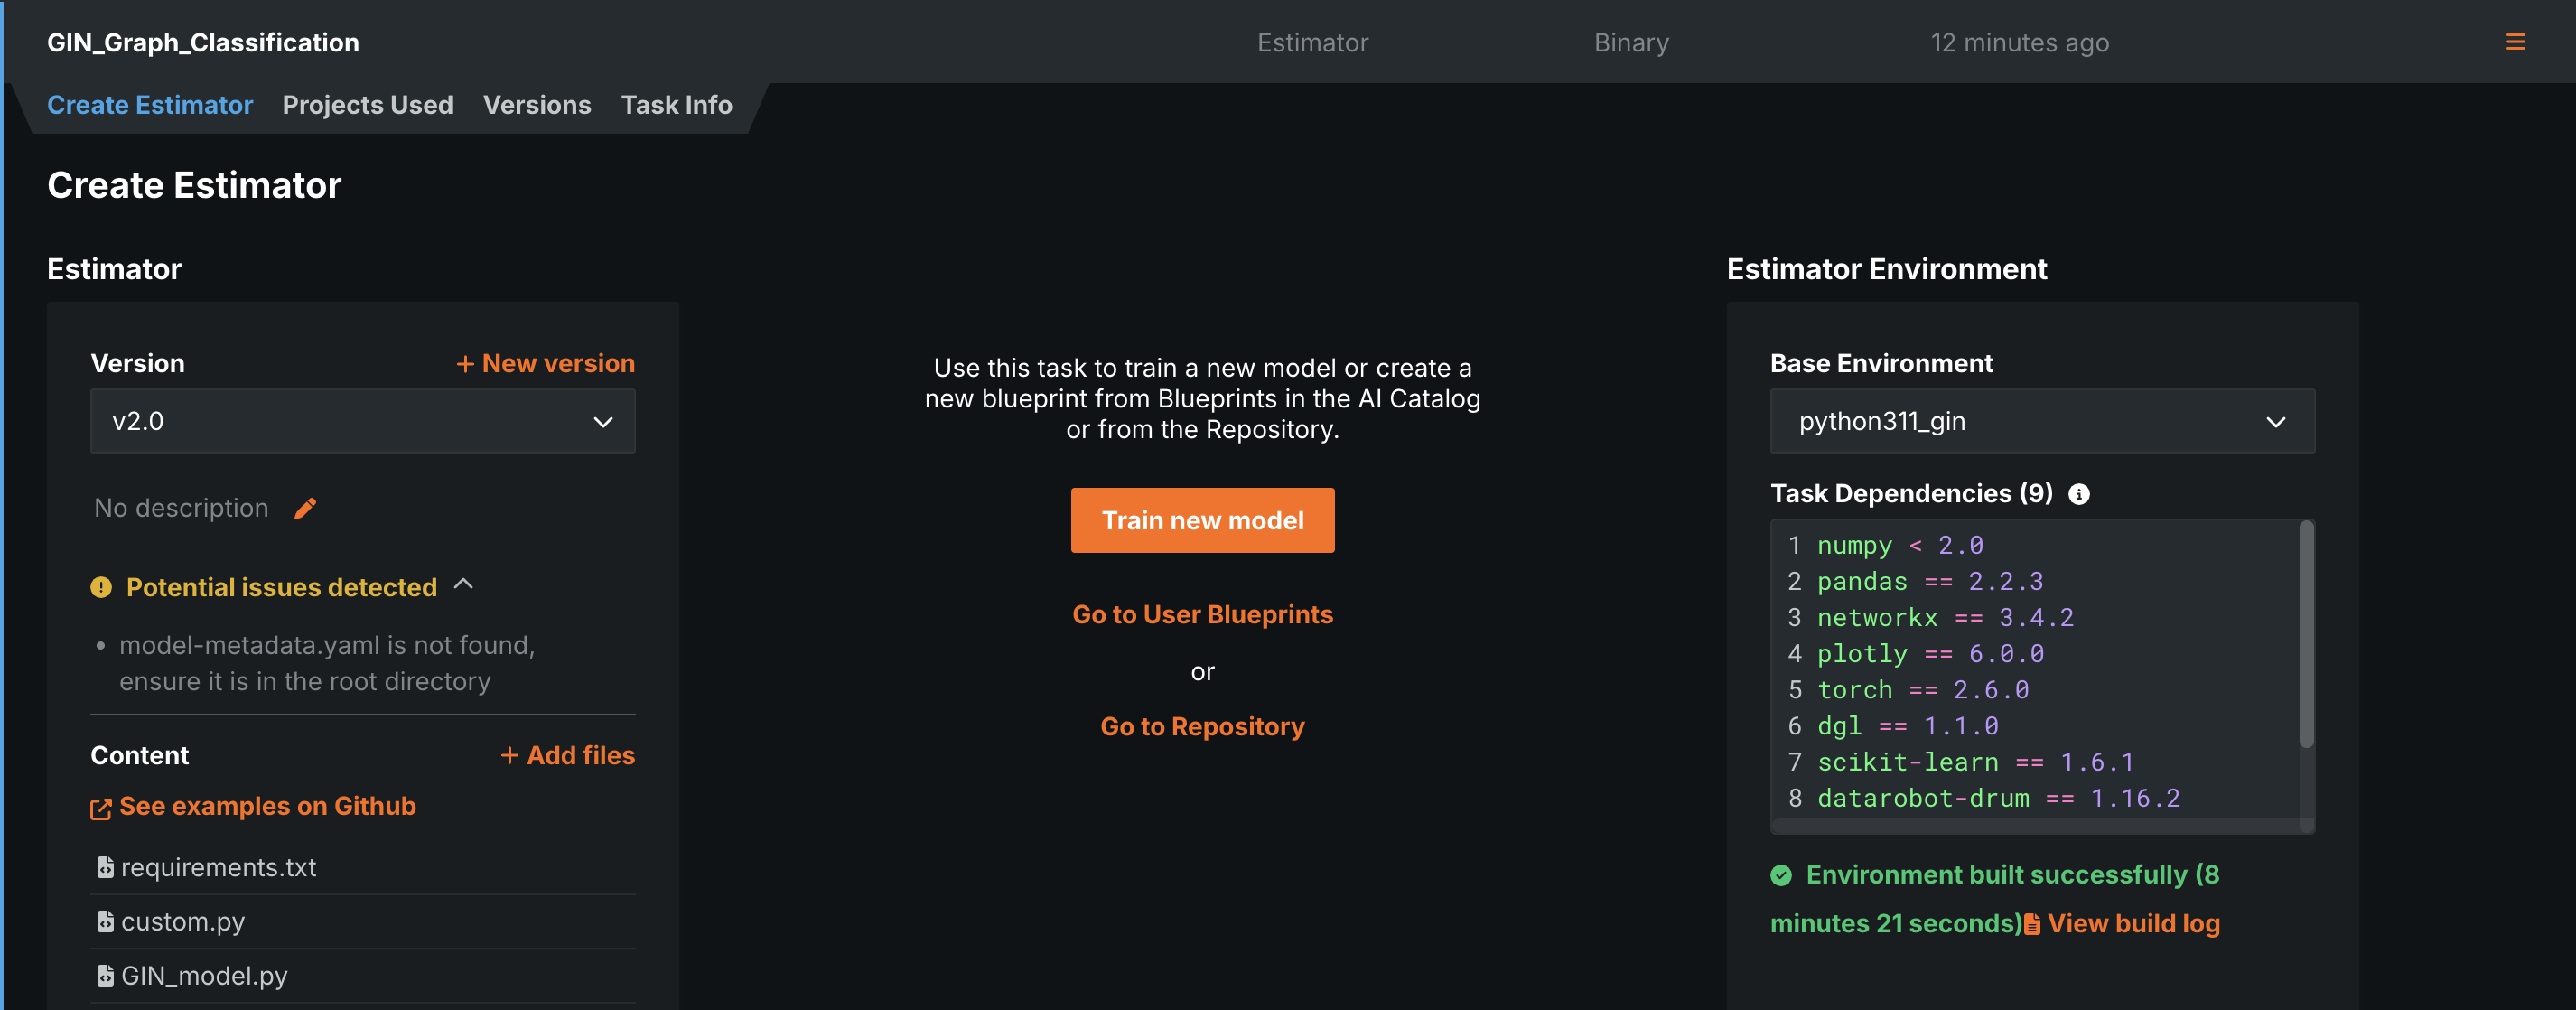

In [26]:
from IPython.display import display, Image

display(Image(filename="./custom_task_deployed.png"))